Dyna Q model, CVAE, reward model and terminal model given

In [1]:
#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
name='Experiment2'

In [3]:
from UCLSE.dyna_q.Experiment1a import Experiment
from UCLSE.dyna_q.dyna_q import TabularMemory
from UCLSE.dyna_q.benchmarking import BenchmarkAgent, SpoofAgent, DoNothing
import numpy as np
import pandas as pd
import os
import torch
import visdom
import matplotlib.pyplot as plt

In [4]:
vis=visdom.Visdom(port=8097)

In [5]:
def reward_oracle(observation,cutoff=50,ub=6,lb=-2,lamb=0.5):


    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    bid_change=observation.bid_change
    bid_ask_spread=observation.bid_ask_spread
    time_left=observation.time_left

    ans=lamb*bid_change

    if inventory==0:   #terminal            
            
            ans+=-(1-lamb)*distance
            ans-=lamb*bid_change

    elif inventory>1: #terminal
            
            ans+=-bid_ask_spread*(inventory-1)
            ans+=-(1-lamb)*distance
            ans+=-1 #penalty
           
    else:

            if orders_out>0: 
                ans+=1/250


            if time_left==1: #terminal takes account of exit spread
               
                ans+=-(1-lamb)*distance

            if -distance>=ub:
                
                ans+=-(1-lamb)*distance
              

            elif -distance<lb:
               
                ans+=-(1-lamb)*distance
               

    return ans 

def done_oracle(observation,cutoff=50,lb=-2,ub=6):

    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    time_left=observation.time_left

    if inventory==0:
        done=1
        why=f'inventory {inventory}=0'
    elif time_left>=1:
        done=1
        why=f'time up {time_left}'
    elif inventory>1:
        done=1
        why=f'inventory {inventory}>1'
    elif -distance>=ub:
        done=1
        why=f'-distance {distance} >ub {ub}'
    elif -distance<lb: 
        done=1
        why=f'-distance {distance}<lb {lb}'

    else:
        done=0 
        why=None
    return done,why

In [41]:
trader_pref_kwargs={'qty_min':-5,'qty_max':5,'sigma_pv':1}
timer_kwargs={'start':0,'end':6000,'step':1}
price_sequence_kwargs={'kappa':0.0002,'mean':100,'sigma':1,'block_length':10}
noise_kwargs={'sigma':1}
messenger_kwargs={'logging':True}
env_kwargs={'trader_arrival_rate':1,'recording':True,#'process_verbose':False,
                'bookkeep_verbose':False, 'lob_verbose':False}
sigma_n=5

def cont_coef():
    return np.random.uniform(0.2,0.8)

def personal_memory():
    return int(np.random.uniform(5,15))

trader_kwargs={'ZIP':{'prefix':'ZIP','number':10,'object_name':'WW_Zip',
                          'setup_kwargs':
                                {'market_make':True,'prior':(100,sigma_n)}},
               'HBL':{'prefix':'HBL','number':10,'object_name':'HBL',
                          'setup_kwargs':
                              {'memory':100,'grace_period':20}},
               'CON':{'prefix':'CON','number':10,'object_name':'ContTrader',
                      'setup_kwargs':
                          {'cont_coeff':cont_coef,'personal_memory':personal_memory,'profit_target':4, 'market_make':True,
                          'prior':(100,sigma_n)}},
               'NOI':{'prefix':'NOI','number':10,'object_name':'NoiseTrader',
                          'setup_kwargs':{'memory':20}}
              }

lb=-1
lamb=0.5
ub=10
cutoff=100

array_reward=array_reward_wrap(lb=loss_limit,lamb=lamb,ub=profit_target)
array_done=array_done_wrap(lb=loss_limit,ub=profit_target)

lobenv_kwargs={'cutoff':100,'profit_target':ub,'loss_limit':lb,'reward_func':reward_oracle,'lamb':0.5}

device='cuda'

In [124]:
def array_reward(observation):
    
    tensor=False
    if type(observation)==torch.Tensor:
        tensor=True
        reward=torch.zeros((observation.shape[0]),device=device,requires_grad = False)
        observation=observation.detach()
    elif type(observation) in (np.array,np.ndarray):
        reward=np.zeros((observation.shape[0]))
    #print('rw shape',reward.shape, 'obs shape',observation.shape)

    distance=observation[:,0]
    inventory=observation[:,1]
    orders_out=observation[:,2]
    bid_change=observation[:,3]
    bid_ask_spread=observation[:,5]
    time_left=observation[:,8]
    
    #print('bc shape', bid_change.shape)

    reward+=lamb*bid_change*10

    invent_0=inventory==0   #terminal                        
    reward[invent_0]+=-(1-lamb)*10*distance[invent_0]
    reward[invent_0]-=lamb*10*bid_change[invent_0]

    invent_1=inventory>1 #terminal    
    reward[invent_1]+=-10*bid_ask_spread[invent_1]*(inventory[invent_1]-1)
    reward[invent_1]+=-(1-lamb)*10*distance[invent_1]
    reward[invent_1]+=-1 #penalty

   #else....
    invent_perfect=(~invent_0&~invent_1)


    #if orders_out>0: 
    if_orders_out=orders_out>0
    if_orders_out=if_orders_out&invent_perfect
    reward[if_orders_out]+=1/250


    #if time_left==1: #terminal takes account of exit spread
    if_time_left=time_left==1
    if_time_left=if_time_left&invent_perfect

    reward[if_time_left]+=-(1-lamb)*10*distance[if_time_left]

    #if -distance>=ub/10:
    if_distance_gr=-distance>ub/10
    if_distance_gr=if_distance_gr&invent_perfect
    reward[if_distance_gr]+=-(1-lamb)*10*distance[if_distance_gr]

    #elif -distance<lb/10:
    if_distance_ls=-distance<lb/10
    if_distance_ls=if_distance_ls&invent_perfect
    reward[if_distance_ls]+=-(1-lamb)*10*distance[if_distance_ls]

    if tensor: reward=reward.unsqueeze(1)
    
    return reward

def array_done(x):
    
    tensor=False
    if type(x)==torch.Tensor:
        tensor=True
        done=torch.zeros((x.shape[0]),device=device,requires_grad = False)
    elif type(x) in (np.array,np.ndarray):
        done=np.zeros((x.shape[0]))

    #inventory
    done[x[:,1]==0]=1

    #time_left
    done[x[:,-1]>=1]=1

    #inventory
    done[x[:,1]>1]=1

    #distance
    done[-x[:,0]>ub/10]=1

    #distance
    done[-x[:,0]<lb/10]=1
    
    if tensor: done=done.unsqueeze(1)

    return done

agent_kwargs={'CVAE':True,'Q_H1Size':16,'Q_H2Size':16,
                   'doneModel':array_done,'rewardModel':array_reward,'loss_func':None,'device':device}

In [125]:
dyna_config={
	"double_q_model": False,
	"batch_size": 64,
	"learning_rate": 5e-3,
	"exploration": {
		"type": "exponential",
		"init_epsilon": 0.8,
		"min_epsilon": 0.05,
		"decay_steps": 100000,
		"decay_eps": 0.99,
        "choice":'least_bonus'
	},
	"memory": {
		"memory_capacity": 1000000,
		"prioritized": False,
        "tabular memory":True,
        
	},
	"discount": 0.99,
	"target_update_freq": 50,
	"first_update": 200,
	"modify_reward": False,
    "learn":'Q',
    'double_q_model':True,
    'model_update_freq':5,
    'planning_freq':5,
    'model':'CVAE'
    
}

In [127]:
experiment=Experiment(trader_pref_kwargs=trader_pref_kwargs,timer_kwargs=timer_kwargs,
           price_sequence_kwargs=price_sequence_kwargs,noise_kwargs=noise_kwargs,
           messenger_kwargs=messenger_kwargs,env_kwargs=env_kwargs,trader_kwargs=trader_kwargs,
           lobenv_kwargs=lobenv_kwargs,agent_kwargs=agent_kwargs,visdom=vis,dyna_kwargs=dyna_config,name=name)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
custom reward function
custom done function
setup tabular memory


In [128]:
experiment.agent.env_model.decoder.reward,experiment.agent.env_model.decoder.done,

(<function __main__.array_reward(observation)>,
 <function __main__.array_done(x)>)

In [ ]:
returns,memory=Experiment.memory_returns_loader(experiment)
project=array_reward(memory.iloc[:,-9:].values)
dones=array_done(memory.iloc[:,-9:].values)
print(memory[(memory.done!=dones)])
memory[(memory.rw!=project)].rw-project[(memory.rw!=project)]

In [130]:
experiment.new_train_setup(MaxEpisodes=1000,planning_steps=1,lookback=30,thresh=3,planning=True,graph=True)

In [122]:
torch.autograd.set_detect_anomaly(True)

In [131]:
experiment.train(MaxEpisodes=10001,start_episode=experiment.episode,folder='Results/'+experiment.name)

Planning is True, double Q model is True, tabular memory is True
Dyna-Q - EXP: 1 | Ep: 21 | timestep: 2 | Ep_r:  0.00396 Profit: -1 Avg loss:-0.17317739428728196
Dyna-Q - EXP: 1 | Ep: 41 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:-0.06501465333333334
Dyna-Q - EXP: 1 | Ep: 61 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:-0.06537896013333332
Saving best checkpoint at episode 72 with reward 0
Dyna-Q - EXP: 1 | Ep: 81 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.000528
Dyna-Q - EXP: 1 | Ep: 101 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.000264
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 121 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.024881999999999998
Saving best checkpoint at episode 123 with reward 0.000528
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 141 | timestep: 1 | Ep_

Dyna-Q - EXP: 1 | Ep: 961 | timestep: 10 | Ep_r:  3.0192471699964782 Profit: 2 Avg loss:-0.08990462153117622
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 981 | timestep: 9 | Ep_r:  -1.9694068989934563 Profit: -5 Avg loss:-0.5076540104348104
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Saving best checkpoint at episode 993 with reward 0.337405945082431
Dyna-Q - EXP: 1 | Ep: 1001 | timestep: 17 | Ep_r:  -1.4411772773535707 Profit: -1 Avg loss:0.5565715428308261
Saving checkpoint at episode 1000
Dyna-Q - EXP: 1 | Ep: 1021 | timestep: 4 | Ep_r:  0.011761596 Profit: -3 Avg loss:0.33068687098565774
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 1041 | timestep: 33 | Ep_r:  -2.64109221303931 Profit: -2 Avg loss:-0.07933695578309988
sequence made
adding exchange to RL trader  RL
adding ex

KeyboardInterrupt: 

In [132]:
experiment.resume(exp=experiment,best=True,folder='Results/'+experiment.name)

=> loading checkpoint 'Results/Experiment2\dyna_best.pth.tar'
=> loaded checkpoint 'Results/Experiment2\dyna_best.pth.tar' (epoch 1141)


C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:799: UserWarning: not double Q
  warnings.warn('not double Q')
C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:816: UserWarning: no optimizer saved
  warnings.warn('no optimizer saved')


keys unused in checkpoint data:  ['episode', 'setup']


In [133]:
experiment.agent.set_device('cpu')
experiment.test_setup(MaxEpisodes=1000)

Device in use is  cpu
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
custom reward function
custom done function
setup tabular memory


C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:555: UserWarning: no eval net for agent, skipping
  warnings.warn('no eval net for agent, skipping')


Dyna-Q - EXP 1, | Ep: , 1, | timestep:  12 | Ep_r: -1.7085539486864518|profit:-3 start:251|end:263
r0 0.5
Dyna-Q - EXP 1, | Ep: , 26, | timestep:  40 | Ep_r: -2.621588703427872|profit:-3 start:3447|end:3487
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 1.0
Dyna-Q - EXP 1, | Ep: , 51, | timestep:  47 | Ep_r: -3.60341015795648|profit:-2 start:1891|end:1938
r0 0.5
r0 0.5
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 76, | timestep:  37 | Ep_r: -1.6297796343476312|profit:-3 start:995|end:1032
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 101, | timestep:  16 | Ep_r: 1.0504168915620498|profit:0 start:206|end:222
r0 0.5
r0 0.5
Dyna-Q - EXP 1, | Ep: , 126, | timestep:  17 | Ep_r: 1.0538227226464292|profit:0 start:3951|end:3968
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 151, |

KeyboardInterrupt: 

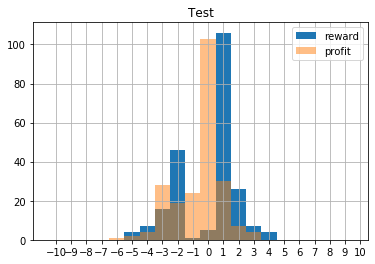

In [135]:
ax,d=experiment.plot_hist_profit(title='Test')

In [137]:
d.describe()

,0,1,2,3,4,5,6
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,2375.950450,2401.000000,2929.166667,110.500000,0.190380,-0.549550,0.096847
std,1497.185067,1499.178146,1719.906639,64.230055,1.868504,1.547082,0.017514
min,19.000000,26.000000,12.000000,0.000000,-4.691177,-6.000000,0.000000
25%,1098.750000,1131.500000,1375.500000,55.250000,-1.644746,-1.000000,0.100000
50%,2239.000000,2250.500000,3068.000000,110.500000,1.036446,0.000000,0.100000
75%,3686.500000,3704.000000,4505.750000,165.750000,1.133306,0.000000,0.100000
max,5102.000000,5116.000000,5561.000000,221.000000,4.067983,3.000000,0.100000
